In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define stock tickers and time range
stocks = ['META', 'MSFT', 'XOM', '^GSPC']
start_date = '2013-01-01'
end_date = '2024-12-31'

In [3]:
# Fetch stock data
data = yf.download(stocks, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


In [4]:
# Extract only the 'Close' prices from MultiIndex
data = data.xs('Close', level='Price', axis=1)

In [5]:
# Compute log returns
data_returns = np.log(data / data.shift(1)).dropna()

In [6]:
# Define major market events
events = pd.DataFrame({
    'Date': pd.to_datetime([
        '2015-08-24',  # China market crash
        '2016-06-24',  # Brexit vote
        '2018-10-10',  # Market correction
        '2020-03-16',  # COVID-19 market crash
        '2021-01-27',  # GameStop short squeeze
        '2021-11-10',  # Inflation Surge Start
        '2022-12-14'   # Inflation Cooldown
    ]),
    'Event': [
        'China Market Crash',
        'Brexit Vote',
        'Market Correction',
        'COVID-19 Crash',
        'GameStop Short Squeeze',
        'Inflation Surge Start',
        'Inflation Cooldown'
    ]
})
events = events.set_index('Date')

In [7]:
# Filter stock return data for event dates
event_returns = data_returns.loc[data_returns.index.isin(events.index)].copy()
event_returns.loc[:, 'Event'] = events['Event']

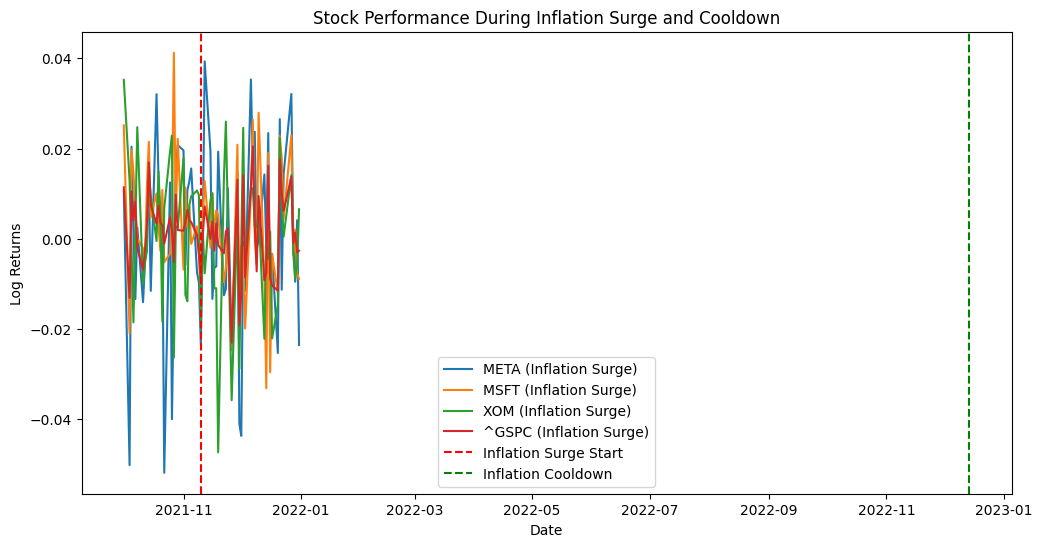

In [8]:
# Plot stock returns during event periods
plt.figure(figsize=(12,6))
for stock in stocks:
    plt.plot(data_returns[stock].loc['2021-10-01':'2022-01-01'], label=f'{stock} (Inflation Surge)')
plt.axvline(pd.to_datetime('2021-11-10'), color='red', linestyle='--', label='Inflation Surge Start')
plt.axvline(pd.to_datetime('2022-12-14'), color='green', linestyle='--', label='Inflation Cooldown')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.title('Stock Performance During Inflation Surge and Cooldown')
plt.show()

In [9]:
# Correlation Analysis Before and After Events
def correlation_analysis(df, event_date, window=30):
    pre_event = df.loc[:event_date].iloc[-window:]
    post_event = df.loc[event_date:].iloc[:window]

    print(f'Correlation before {event_date}:')
    print(pre_event.corr())
    print(f'\nCorrelation after {event_date}:')
    print(post_event.corr())

    return pre_event.corr(), post_event.corr()

In [10]:
# Example correlation shift analysis for COVID-19 crash
corr_before, corr_after = correlation_analysis(data_returns, '2020-03-16')

Correlation before 2020-03-16:
Ticker      META      MSFT       XOM     ^GSPC
Ticker                                        
META    1.000000  0.967846  0.807591  0.954923
MSFT    0.967846  1.000000  0.799044  0.957226
XOM     0.807591  0.799044  1.000000  0.872238
^GSPC   0.954923  0.957226  0.872238  1.000000

Correlation after 2020-03-16:
Ticker      META      MSFT       XOM     ^GSPC
Ticker                                        
META    1.000000  0.900114  0.647863  0.875041
MSFT    0.900114  1.000000  0.678508  0.948855
XOM     0.647863  0.678508  1.000000  0.809707
^GSPC   0.875041  0.948855  0.809707  1.000000


In [11]:
# Event Impact Analysis: Stock Volatility Changes
volatility_before = data_returns.rolling(window=30).std().loc[:'2020-03-16'].iloc[-1]
volatility_after = data_returns.rolling(window=30).std().loc['2020-03-16':].iloc[0]

In [12]:
print("Stock Volatility Before COVID-19 Crash:")
print(volatility_before)

Stock Volatility Before COVID-19 Crash:
Ticker
META     0.046036
MSFT     0.054176
XOM      0.044062
^GSPC    0.042825
Name: 2020-03-16 00:00:00, dtype: float64


In [13]:
print("\nStock Volatility After COVID-19 Crash:")
print(volatility_after)


Stock Volatility After COVID-19 Crash:
Ticker
META     0.046036
MSFT     0.054176
XOM      0.044062
^GSPC    0.042825
Name: 2020-03-16 00:00:00, dtype: float64


In [14]:
# Event Impact on Mean Returns
mean_returns_before = data_returns.loc[:'2020-03-16'].mean()
mean_returns_after = data_returns.loc['2020-03-16':].mean()

In [15]:
print("Stock Mean Returns Before COVID-19 Crash:")
print(mean_returns_before)

Stock Mean Returns Before COVID-19 Crash:
Ticker
META     0.000911
MSFT     0.000970
XOM     -0.000377
^GSPC    0.000270
dtype: float64


In [16]:
print("\nStock Mean Returns After COVID-19 Crash:")
print(mean_returns_after)


Stock Mean Returns After COVID-19 Crash:
Ticker
META     0.001034
MSFT     0.000850
XOM      0.001035
^GSPC    0.000645
dtype: float64


In [17]:
# Display significant event-based movements
print("Stock movements during major events:")
print(event_returns)

Stock movements during major events:
Ticker          META      MSFT       XOM     ^GSPC                   Event
Date                                                                      
2015-08-24 -0.047229 -0.032805 -0.048429 -0.040211      China Market Crash
2016-06-24 -0.026415 -0.040894 -0.026604 -0.036581             Brexit Vote
2018-10-10 -0.042169 -0.055870 -0.023272 -0.033416       Market Correction
2020-03-16 -0.153769 -0.159453 -0.100069 -0.127652          COVID-19 Crash
2021-01-27 -0.035768  0.002450 -0.011401 -0.026013  GameStop Short Squeeze
2021-11-10 -0.023319 -0.015448 -0.019897 -0.008260   Inflation Surge Start
2022-12-14  0.011914  0.001167 -0.007393 -0.006071      Inflation Cooldown
